# Import all essential libraries required for data preprocessing, modeling, and interpretability in this experiment.

In [132]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Import and display the dataset to begin preprocessing and model development.

In [133]:
df = pd.read_csv("breast_cancer.csv")
df.head()

,Age,Race,Marital Status,Unnamed: 3,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,43,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N3,IIIC,Moderately differentiated; Grade II,Regional,40,Positive,Positive,19,11,1,Alive
1,47,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N2,IIIA,Moderately differentiated; Grade II,Regional,45,Positive,Positive,25,9,2,Alive
2,67,White,Married (including common law),NaN,T2,N1,IIB,Poorly differentiated; Grade III,Regional,25,Positive,Positive,4,1,2,Dead
3,46,White,Divorced,NaN,T1,N1,IIA,Moderately differentiated; Grade II,Regional,19,Positive,Positive,26,1,2,Dead
4,63,White,Married (including common law),NaN,T2,N2,IIIA,Moderately differentiated; Grade II,Regional,35,Positive,Positive,21,5,3,Dead


In [134]:
df.describe()

,Age,Unnamed: 3,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months
count,4024.000000,0.0,4024.000000,4024.000000,4024.000000,4024.000000
mean,53.972167,NaN,30.473658,14.357107,4.158052,71.297962
std,8.963134,NaN,21.119696,8.099675,5.109331,22.921430
min,30.000000,NaN,1.000000,1.000000,1.000000,1.000000
25%,47.000000,NaN,16.000000,9.000000,1.000000,56.000000
50%,54.000000,NaN,25.000000,14.000000,2.000000,73.000000
75%,61.000000,NaN,38.000000,19.000000,5.000000,90.000000
max,69.000000,NaN,140.000000,61.000000,46.000000,107.000000


# Convert the 'Survival Months' column to numeric format to ensure consistency and handle potential non-numeric values (just in case).

In [135]:
df['Survival Months'] = pd.to_numeric(df['Survival Months'], errors='coerce')

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     4024 non-null   int64  
 1   Race                    4024 non-null   object 
 2   Marital Status          4024 non-null   object 
 3   Unnamed: 3              0 non-null      float64
 4   T Stage                 4024 non-null   object 
 5   N Stage                 4024 non-null   object 
 6   6th Stage               4024 non-null   object 
 7   Grade                   4024 non-null   object 
 8   A Stage                 4024 non-null   object 
 9   Tumor Size              4024 non-null   int64  
 10  Estrogen Status         4024 non-null   object 
 11  Progesterone Status     4024 non-null   object 
 12  Regional Node Examined  4024 non-null   int64  
 13  Reginol Node Positive   4024 non-null   int64  
 14  Survival Months         4024 non-null   

# Convert the 'Survival Months' column to numeric format to ensure consistency and handle potential non-numeric values (just in case).

In [137]:
df['Survival Months'] = pd.to_numeric(df['Survival Months'], errors='coerce')

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     4024 non-null   int64  
 1   Race                    4024 non-null   object 
 2   Marital Status          4024 non-null   object 
 3   Unnamed: 3              0 non-null      float64
 4   T Stage                 4024 non-null   object 
 5   N Stage                 4024 non-null   object 
 6   6th Stage               4024 non-null   object 
 7   Grade                   4024 non-null   object 
 8   A Stage                 4024 non-null   object 
 9   Tumor Size              4024 non-null   int64  
 10  Estrogen Status         4024 non-null   object 
 11  Progesterone Status     4024 non-null   object 
 12  Regional Node Examined  4024 non-null   int64  
 13  Reginol Node Positive   4024 non-null   int64  
 14  Survival Months         4024 non-null   

# Create the new target: Survival_5yr

In [139]:
df['Survival_5yr'] = np.where(df['Survival Months'] >= 60, 1, 0)

In [140]:
df.dropna(subset=['Survival Months'], inplace=True)

In [141]:
df.columns

Index(['Age', 'Race ', 'Marital Status', 'Unnamed: 3', 'T Stage ', 'N Stage',
       '6th Stage', 'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months', 'Status', 'Survival_5yr'],
      dtype='object')

In [142]:
df.head()

,Age,Race,Marital Status,Unnamed: 3,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status,Survival_5yr
0,43,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N3,IIIC,Moderately differentiated; Grade II,Regional,40,Positive,Positive,19,11,1,Alive,0
1,47,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N2,IIIA,Moderately differentiated; Grade II,Regional,45,Positive,Positive,25,9,2,Alive,0
2,67,White,Married (including common law),NaN,T2,N1,IIB,Poorly differentiated; Grade III,Regional,25,Positive,Positive,4,1,2,Dead,0
3,46,White,Divorced,NaN,T1,N1,IIA,Moderately differentiated; Grade II,Regional,19,Positive,Positive,26,1,2,Dead,0
4,63,White,Married (including common law),NaN,T2,N2,IIIA,Moderately differentiated; Grade II,Regional,35,Positive,Positive,21,5,3,Dead,0


In [143]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("Categorical columns that will be one-hot encoded:")
print(categorical_cols)

Categorical columns that will be one-hot encoded:
Index(['Race ', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage', 'Grade',
       'A Stage', 'Estrogen Status', 'Progesterone Status', 'Status'],
      dtype='object')


In [144]:
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

Race : ['Other (American Indian/AK Native, Asian/Pacific Islander)' 'White'
 'Black']
Marital Status: ['Married (including common law)' 'Divorced' 'Single (never married)'
 'Widowed' 'Separated']
T Stage : ['T2' 'T1' 'T3' 'T4']
N Stage: ['N3' 'N2' 'N1']
6th Stage: ['IIIC' 'IIIA' 'IIB' 'IIA' 'IIIB']
Grade: ['Moderately differentiated; Grade II' 'Poorly differentiated; Grade III'
 'Well differentiated; Grade I' 'Undifferentiated; anaplastic; Grade IV']
A Stage: ['Regional' 'Distant']
Estrogen Status: ['Positive' 'Negative']
Progesterone Status: ['Positive' 'Negative']
Status: ['Alive' 'Dead']


In [145]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("Categorical columns that will be one-hot encoded:")
print(categorical_cols)

Categorical columns that will be one-hot encoded:
Index(['Race ', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage', 'Grade',
       'A Stage', 'Estrogen Status', 'Progesterone Status', 'Status'],
      dtype='object')


In [146]:
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

Race : ['Other (American Indian/AK Native, Asian/Pacific Islander)' 'White'
 'Black']
Marital Status: ['Married (including common law)' 'Divorced' 'Single (never married)'
 'Widowed' 'Separated']
T Stage : ['T2' 'T1' 'T3' 'T4']
N Stage: ['N3' 'N2' 'N1']
6th Stage: ['IIIC' 'IIIA' 'IIB' 'IIA' 'IIIB']
Grade: ['Moderately differentiated; Grade II' 'Poorly differentiated; Grade III'
 'Well differentiated; Grade I' 'Undifferentiated; anaplastic; Grade IV']
A Stage: ['Regional' 'Distant']
Estrogen Status: ['Positive' 'Negative']
Progesterone Status: ['Positive' 'Negative']
Status: ['Alive' 'Dead']


# Apply one-hot encoding to transform categorical variables into binary indicator variables, while dropping the first category to prevent multicollinearity.


In [147]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [148]:
df.head()

,Age,Race,Marital Status,Unnamed: 3,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status,Survival_5yr
0,43,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N3,IIIC,Moderately differentiated; Grade II,Regional,40,Positive,Positive,19,11,1,Alive,0
1,47,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N2,IIIA,Moderately differentiated; Grade II,Regional,45,Positive,Positive,25,9,2,Alive,0
2,67,White,Married (including common law),NaN,T2,N1,IIB,Poorly differentiated; Grade III,Regional,25,Positive,Positive,4,1,2,Dead,0
3,46,White,Divorced,NaN,T1,N1,IIA,Moderately differentiated; Grade II,Regional,19,Positive,Positive,26,1,2,Dead,0
4,63,White,Married (including common law),NaN,T2,N2,IIIA,Moderately differentiated; Grade II,Regional,35,Positive,Positive,21,5,3,Dead,0


In [149]:
df.columns = df.columns.str.strip()

# Assume df is your DataFrame and the target variable is in 'Survival_5yr'

In [150]:
X = df.drop(columns='Survival_5yr')
y = df['Survival_5yr']

# Convert object columns to dummy/indicator variables

In [151]:
X = pd.get_dummies(X, drop_first=True)

In [152]:
X

,Age,Unnamed: 3,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months,"Race_Other (American Indian/AK Native, Asian/Pacific Islander)",Race_White,Marital Status_Married (including common law),Marital Status_Separated,...,6th Stage_IIIA,6th Stage_IIIB,6th Stage_IIIC,Grade_Poorly differentiated; Grade III,Grade_Undifferentiated; anaplastic; Grade IV,Grade_Well differentiated; Grade I,A Stage_Regional,Estrogen Status_Positive,Progesterone Status_Positive,Status_Dead
0,43,NaN,40,19,11,1,True,False,True,False,...,False,False,True,False,False,False,True,True,True,False
1,47,NaN,45,25,9,2,True,False,True,False,...,True,False,False,False,False,False,True,True,True,False
2,67,NaN,25,4,1,2,False,True,True,False,...,False,False,False,True,False,False,True,True,True,True
3,46,NaN,19,26,1,2,False,True,False,False,...,False,False,False,False,False,False,True,True,True,True
4,63,NaN,35,21,5,3,False,True,True,False,...,True,False,False,False,False,False,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,52,NaN,10,19,1,107,False,True,True,False,...,False,False,False,False,False,True,True,True,True,False
4020,53,NaN,9,13,5,107,False,True,True,False,...,True,False,False,True,False,False,True,False,False,False
4021,53,NaN,9,4,2,107,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
4022,60,NaN,9,14,2,107,True,False,True,False,...,False,False,False,False,False,False,True,True,True,False


In [153]:
print("Dummy columns after one-hot encoding:")
print(X.columns.tolist())

Dummy columns after one-hot encoding:
['Age', 'Unnamed: 3', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months', 'Race_Other (American Indian/AK Native, Asian/Pacific Islander)', 'Race_White', 'Marital Status_Married (including common law)', 'Marital Status_Separated', 'Marital Status_Single (never married)', 'Marital Status_Widowed', 'T Stage_T2', 'T Stage_T3', 'T Stage_T4', 'N Stage_N2', 'N Stage_N3', '6th Stage_IIB', '6th Stage_IIIA', '6th Stage_IIIB', '6th Stage_IIIC', 'Grade_Poorly differentiated; Grade III', 'Grade_Undifferentiated; anaplastic; Grade IV', 'Grade_Well differentiated; Grade I', 'A Stage_Regional', 'Estrogen Status_Positive', 'Progesterone Status_Positive', 'Status_Dead']


In [154]:
y

0       0
1       0
2       0
3       0
4       0
       ..
4019    1
4020    1
4021    1
4022    1
4023    1
Name: Survival_5yr, Length: 4024, dtype: int32

In [155]:
print(X.dtypes[X.dtypes == 'object'])

Series([], dtype: object)


# Split the dataset into training and testing subsets, with 80% of the data used for training and 20% reserved for testing. A fixed random state ensures reproducibility.

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ROC curve (Receiver Operating Characteristic curve) for a Random Forest model

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

base_model = RandomForestClassifier(random_state=42)
base_model.fit(X_train, y_train)

feat_importances = pd.Series(base_model.feature_importances_, index=X_train.columns)
top_features = feat_importances.sort_values(ascending=False).head(10).index

X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

best_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)
best_model.fit(X_train_top, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,5
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# Predict probabilities for ROC-AUC and plot

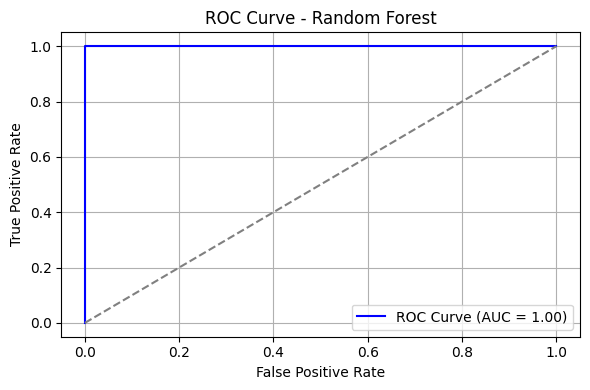

In [158]:
y_probs = best_model.predict_proba(X_test_top)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()